In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from PIL import Image

Using TensorFlow backend.


In [2]:
import keras.backend as K
K.set_image_data_format('channels_first')
K.set_floatx('float32')
print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))

Backend:        tensorflow
Data format:    channels_first


In [131]:
K.image_data_format()

'channels_first'

In [3]:
file = pd.read_csv("fer2013/fer2013.csv")

In [4]:
file.head()

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

In [5]:
file.shape

(35887, 3)

In [6]:
file["Usage"].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [7]:
file.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

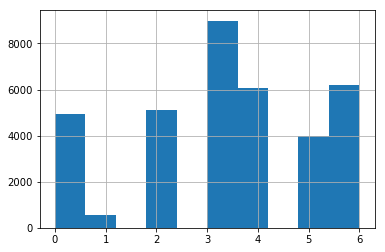

In [8]:
#Imbalanced Classes
file.emotion.hist()

In [9]:
file.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [10]:
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
dict_emo = {0: "Angry",
            1: "Disgust",
            2: "Fear",
            3: "Happy",
            4: "Sad",
            5: "Surprise",
            6: "Neutral"}
dict_emo

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Sad',
 5: 'Surprise',
 6: 'Neutral'}

In [11]:
file[file['Usage']=="PrivateTest"].head()

emotion                                             pixels        Usage
32298        0  170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...  PrivateTest
32299        5  7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...  PrivateTest
32300        6  232 240 241 239 237 235 246 117 24 24 22 13 12...  PrivateTest
32301        4  200 197 149 139 156 89 111 58 62 95 113 117 11...  PrivateTest
32302        2  40 28 33 56 45 33 31 78 152 194 200 186 196 20...  PrivateTest

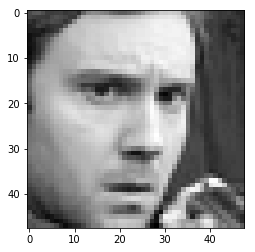

In [12]:
image = pd.to_numeric(file.pixels[0].split())
plt.imshow(image.reshape((48,48)),cmap='gray')

In [206]:
#Transform each "image string" to "image float", reshape to 48x48 and normalize dividing by 255
n_samples = file.shape[0]
images = np.zeros((n_samples,48,48))

for i in range(n_samples):
    images[i] = np.fromstring(file['pixels'][i], dtype=float, sep=' ').reshape(48, 48)

images = images.reshape(n_samples,-1)
#images /=255.
#reshape to default format(n_samples,channel,w,h)
images = images.reshape((n_samples,1,48,48))

In [207]:
images.shape

(35887, 1, 48, 48)

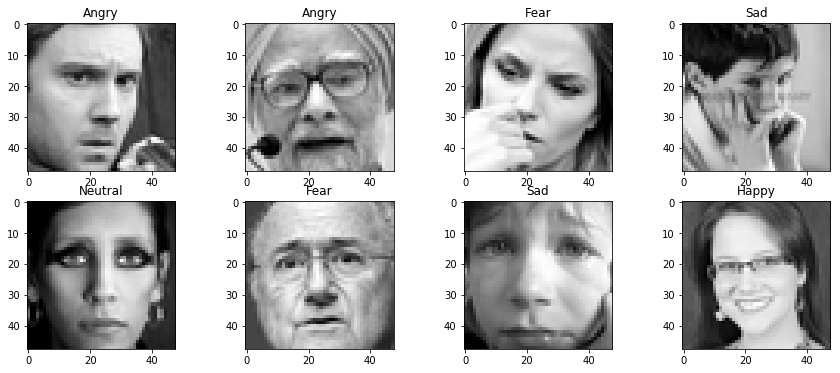

In [208]:
fig = plt.figure(figsize=(15,6))
for i,x in enumerate(images):
    #print(i,x.reshape(48,48))
    if i<8:
        fig.add_subplot(2,4, i+1)
        plt.imshow(x.reshape(48,48), cmap='gray')
        plt.title(dict_emo[file.emotion[i]])

## Dividing data in 3 sets

In [209]:
#Train
train = file[file['Usage']=="Training"]
y_train = train.emotion #debug

In [210]:
X_train = images[:train.shape[0]]
X_train.shape

(28709, 1, 48, 48)

In [211]:
#Test
test = file[file['Usage']=="PublicTest"]
y_test = test.emotion
y_test.shape

(3589,)

In [212]:
min_t = test.index.values.min()
max_t = test.index.values.max()

In [213]:
X_test = images[min_t:max_t+1]
X_test.shape

(3589, 1, 48, 48)

In [214]:
#Validation
val = file[file['Usage']=="PrivateTest"]
y_val = val.emotion
y_val.shape

(3589,)

In [215]:
min_v = val.index.values.min()
max_v = val.index.values.max()

In [216]:
X_val = images[min_v:]
X_val.shape

(3589, 1, 48, 48)

In [217]:
#Just execute this cell to debug purposes, choosing a number of samples in debug(n_samples)
def debug(qtde):
    q_t = int(qtde*0.1)
    y_train = train[:qtde].emotion
    X_train = images[:qtde]
    y_test = test[:q_t].emotion
    X_test = images[min_t:min_t+q_t]
    y_val = val[:q_t].emotion
    X_val = images[min_v:min_v+q_t]
    print (y_train.shape,X_train.shape,y_test.shape,X_test.shape,y_val.shape,X_val.shape)
    return y_train,X_train,y_test,X_test,y_val,X_val
        
y_train,X_train,y_test,X_test,y_val,X_val = debug(4000)

(4000,) (4000, 1, 48, 48) (400,) (400, 1, 48, 48) (400,) (400, 1, 48, 48)


## One-hot encoding

In [218]:
def one_hot(y_train,y_test,y_val):
    y_train_oh = np_utils.to_categorical(y_train)
    y_test_oh = np_utils.to_categorical(y_test)
    y_val_oh = np_utils.to_categorical(y_val)
    print (y_train_oh.shape,y_test_oh.shape,y_val_oh.shape)
    return y_train_oh,y_test_oh,y_val_oh
    
y_train_oh,y_test_oh,y_val_oh = one_hot(y_train,y_test,y_val)

(4000, 7) (400, 7) (400, 7)


In [219]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# dimensions of our images.
img_width, img_height = 48, 48

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
       rescale=1./255,         # sempre faz o rescale
       shear_range=0.2,        # sorteio? entre 0 e 0.2 distribuição uniforme
       zoom_range=0.2,         # sorteio? entre 0 e 0.2
       horizontal_flip=True)   # sorteio 50%

train_datagen_no_augm = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing: only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

In [220]:
nb_train_samples = X_train.shape[0]
nb_validation_samples = X_val.shape[0]
nb_test_samples = X_test.shape[0]

batch_size = 32

train_generator_no_augm = train_datagen_no_augm.flow(X_train, y_train_oh,batch_size=batch_size)

train_generator = train_datagen.flow(X_train, y_train_oh,batch_size=batch_size)

val_generator = val_datagen.flow(X_val,y_val_oh,batch_size=batch_size)

test_generator = val_datagen.flow(X_test,y_test_oh,batch_size=batch_size)

In [221]:
X_train[0]

array([[[  70.,   80.,   82., ...,   52.,   43.,   41.],
        [  65.,   61.,   58., ...,   56.,   52.,   44.],
        [  50.,   43.,   54., ...,   49.,   56.,   47.],
        ..., 
        [  91.,   65.,   42., ...,   72.,   56.,   43.],
        [  77.,   82.,   79., ...,  105.,   70.,   46.],
        [  77.,   72.,   84., ...,  106.,  109.,   82.]]])

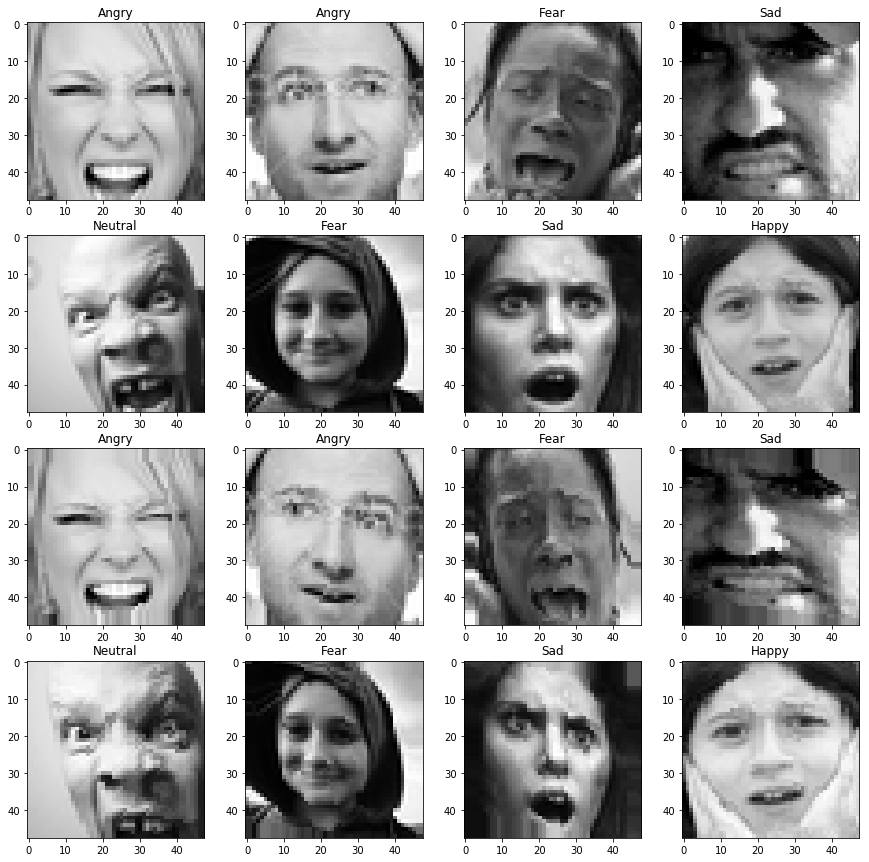

In [222]:
#Mostrando o funcionamento do ImageDataGenerator para 8 imagens

fig = plt.figure(figsize=(15,15))

#for i, j in enumerate(nr.randint(0, 1000, N))

for i,x in enumerate(np.random.randint(0, X_train.shape[0], 8)):
    #print(i,x.reshape(48,48))
    if i<8:
        fig.add_subplot(4,4, i+1)
        plt.imshow(X_train[x].reshape(48,48), cmap='gray')
        plt.title(dict_emo[file.emotion[i]])
        generator = train_datagen.flow(X_train[x].reshape(1,1,48,48), y_train_oh[i].reshape(1,7), batch_size=8)
        
        X, y = generator.next()
        fig.add_subplot(4, 4, i+9)
        plt.imshow(X.reshape(48,48), cmap='gray')
        plt.title(dict_emo[file.emotion[i]])

            

## CNN

In [223]:
def model_build(nb_classes = 7):
    img_rows, img_cols = 48, 48 # Dimensões das imagens
    input_shape = (1, img_rows, img_cols)

    # Definindo a rede
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Dropout(0.5))

    # Aqui os features deixam de ser imagens
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    return model

model = model_build()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 46, 46)        320       
_________________________________________________________________
activation_16 (Activation)   (None, 32, 46, 46)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 23, 23)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 21, 21)        9248      
_________________________________________________________________
activation_17 (Activation)   (None, 32, 21, 21)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 10, 10)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 8, 8)          9248      
__________

In [224]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [225]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

# define early stopping callback
earlystop = EarlyStopping(monitor='val_acc', 
                          patience=5, 
                          verbose=1, 
                          mode='auto')

# checkpoint
filepath="weights{}.best.hdf5".format(y_train.shape[0])
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [226]:
#batch_size=32
epochs=100
train_steps = nb_train_samples / batch_size
valid_steps = nb_validation_samples / batch_size


#To train the CNN again, please uncomment this line
#model.fit(X_train, y_train_oh, batch_size=batch_size, validation_data=(X_val, y_val_oh), epochs=epochs, callbacks=[learning_rate_reduction, earlystop, checkpoint], verbose=1)# validation_data=(X_test, y_test))

#Using the Generator
model.fit_generator(train_generator, steps_per_epoch=train_steps,
                            validation_data=val_generator, validation_steps=valid_steps,
                            epochs=epochs, verbose=1, callbacks=[learning_rate_reduction, earlystop, checkpoint])

#model.fit(x_train, y_train_oh, batch_size=batch_size, validation_data=(X_test, y_test_oh), epochs=epochs,callbacks=[learning_rate_reduction, earlystop, checkpoint], verbose=1)# validation_data=(X_test, y_test))

Epoch 1/100
125/125 [==============================] - 73s - loss: 1.8515 - acc: 0.2360 - val_loss: 1.8306 - val_acc: 0.2275
Epoch 2/100
125/125 [==============================] - 73s - loss: 1.8232 - acc: 0.2377 - val_loss: 1.8294 - val_acc: 0.2325
Epoch 3/100
125/125 [==============================] - 74s - loss: 1.8057 - acc: 0.2560 - val_loss: 1.7547 - val_acc: 0.2450
Epoch 4/100
125/125 [==============================] - 73s - loss: 1.7794 - acc: 0.2548 - val_loss: 1.7524 - val_acc: 0.2850
Epoch 5/100
125/125 [==============================] - 74s - loss: 1.7554 - acc: 0.2677 - val_loss: 1.7265 - val_acc: 0.2525
Epoch 6/100
125/125 [==============================] - 76s - loss: 1.7323 - acc: 0.2903 - val_loss: 1.6938 - val_acc: 0.2725
Epoch 7/100
125/125 [==============================] - 82s - loss: 1.7163 - acc: 0.2928 - val_loss: 1.6414 - val_acc: 0.3275
Epoch 8/100
125/125 [==============================] - 75s - loss: 1.6891 - acc: 0.3152 - val_loss: 1.6623 - val_acc: 0.3200


In [227]:
# load weights

model.load_weights("weights4000.best.hdf5")

In [228]:
#loss, accuracy = model.evaluate(X_test, y_test_oh, batch_size=128, verbose=1)
#print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))

loss, accuracy = model.evaluate_generator(test_generator, nb_validation_samples)
print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


[INFO] accuracy on the test data set: 46.26% [1.44452]


In [229]:
print('Rótulos conj. teste:',y_test[:10])

y_hat = model.predict_classes(X_test[:10],verbose=0)
print('Rótulos previstos:  ',y_hat[:10])

y_prob = model.predict_proba(X_test[:10],verbose=0)
print('probabilidades:\n',y_prob.max(axis=1))

Rótulos conj. teste: 28709    0
28710    1
28711    4
28712    6
28713    3
28714    3
28715    2
28716    0
28717    2
28718    0
Name: emotion, dtype: int64
Rótulos previstos:   [2 2 2 5 3 5 2 2 0 5]
probabilidades:
 [ 1.          1.          0.87518108  1.          1.          0.99302614
  1.          1.          0.69614393  1.        ]


In [230]:
y_prob = model.predict_proba(X_test,verbose=0).max(axis=1)
y_hat = model.predict_classes(X_test,verbose=0)
acc = (y_hat == y_test).sum()/y_hat.size
print('Acurácia:', acc)

Acurácia: 0.2775


In [252]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.12  0.    0.45  0.07  0.    0.37  0.  ]
 [ 0.1   0.    0.3   0.    0.    0.6   0.  ]
 [ 0.04  0.    0.42  0.04  0.    0.49  0.02]
 [ 0.01  0.    0.25  0.35  0.    0.38  0.  ]
 [ 0.05  0.    0.4   0.1   0.    0.45  0.  ]
 [ 0.    0.    0.06  0.02  0.    0.92  0.  ]
 [ 0.    0.    0.36  0.06  0.    0.58  0.  ]]


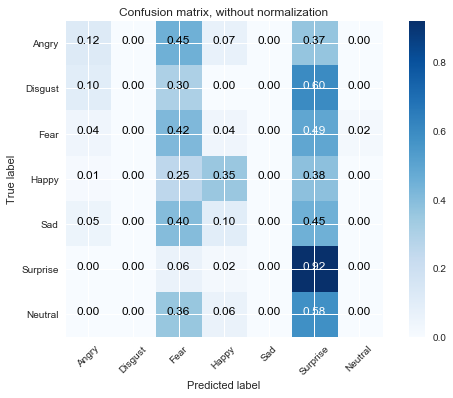

In [260]:
from sklearn.metrics import confusion_matrix

#confusion_matrix(y_test, y_hat)
names = ["Angry","Disgust","Fear","Happy", "Sad","Surprise","Neutral"]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=names,
                      title='Confusion matrix, without normalization',normalize=True)


In [261]:
import seaborn as sns

def correlation_map(dataframe, x,y):
    corr = dataframe.corr(method='pearson')
    _ , ax = plt.subplots(figsize = ( x , y ) )
    sns.heatmap(corr, cmap="YlGnBu", annot=True, square = True, ax=ax)

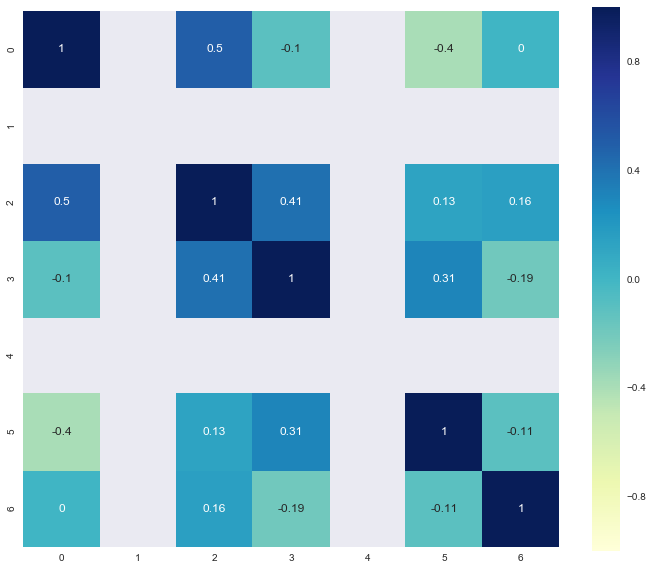

In [262]:

size1 = 12
size2 = 10

correlation_map(pd.DataFrame(confusion_matrix(y_test, y_hat,labels=[0,1,2,3,4,5,6])), size1, size2)

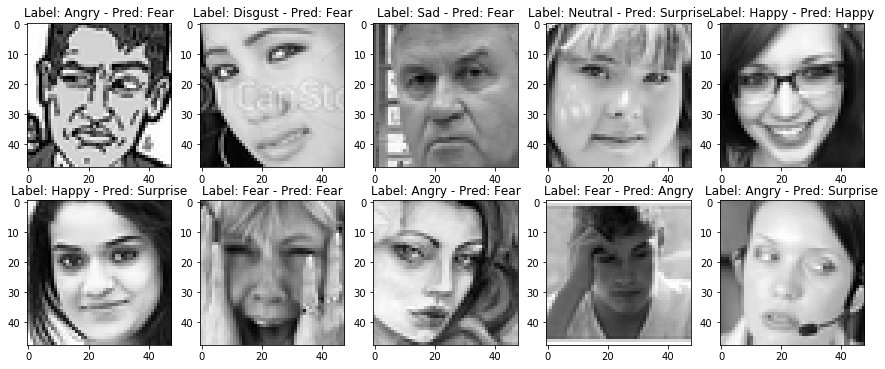

In [232]:
fig = plt.figure(figsize=(15,6))
for i,x in enumerate(X_test):
    #print(i,x.reshape(48,48))
    if i<10:
        fig.add_subplot(2,5, i+1)
        plt.imshow(x.reshape(48,48), cmap='gray')
        plt.title("Label: " + dict_emo[y_test[i+28709]] + " - Pred: " + dict_emo[y_hat[i]])

In [233]:
#From https://www.superdatascience.com/opencv-face-detection/

In [234]:
def convertToRGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
def convertToGray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [235]:
import cv2
import time

cam = cv2.VideoCapture(-1)

#cv2.namedWindow("test") 
#cv2.namedWindow("test2")

img_counter = 0
count = 0
frame_name = []

while True:
    ret, frame = cam.read()
    time.sleep(1/1000)
    #cv2.imshow("test", frame)    
    #cv2.imshow("test2", frame)
    
    if not ret:
        break
    k = cv2.waitKey(1)

    if k%256 == 27: 
        # ESC pressed
        print("Escape hit, closing...")
        break
    else:#if k%256 == 32:
        print(frame.shape)
        
        gray_img = convertToGray(frame)
        #plt.imshow(gray_img,cmap='gray')
        #cv2.imshow("teste2", gray_img)
        
        haar_face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
        faces = haar_face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5);
        #print the number of faces found                 
        print("Faces found: ", len(faces))
        
        for (x,y,w,h) in faces:
            print(y)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        if (len(faces))==0:
            x=y=w=h=10
        
        #cv2.imshow("test2", frame)
        
        crop_img = frame[y: y+h, x: x+w]
        cv2.imwrite("face.png",crop_img)
        #cv2.imshow("test2", crop_img )
        
        gray_img = convertToGray(crop_img)
        img_out = cv2.resize(gray_img,(48,48),interpolation = cv2.INTER_CUBIC)
        cv2.imshow("test2", img_out)
        
        predicted_image = model.predict_classes(img_out.reshape(1,1,48,48),verbose=0)
        emotion = dict_emo[predicted_image[0]]
        print (emotion)
        y_prob = model.predict_proba(img_out.reshape(1,1,48,48),verbose=0)
        print(y_prob)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        #x = 10 #position of text
        #y = 20 #position of text
        cv2.putText(frame,emotion, (x+ int(w/3),y-5),font,0.55,(0,255,0),1) #Draw the text
        cv2.imshow("test3", frame)
        
        #if emotion == "Happy":
            #winsound.PlaySound('teste.wav', winsound.SND_FILENAME)
            
        #time.sleep(2)
        # SPACE pressed                      
        #img_name = "opencv_frame_{}.png".format(img_co unter)
        #cv2.imwrite(img_name, frame)
        #print("{} written!".format(img_name))
        #img_counter += 1

cam.release()

cv2.destroyAllWindows()

(480, 640, 3)
Faces found:  1
172
Fear
[[  1.30274697e-04   2.66601905e-15   8.67119253e-01   6.29592421e-07
    9.48519414e-08   1.32749602e-01   1.75878881e-07]]
(480, 640, 3)
Faces found:  1
179
Fear
[[  2.61539953e-05   6.43060208e-28   9.82772589e-01   3.22664884e-04
    5.77258456e-13   1.68785695e-02   1.22338755e-16]]
(480, 640, 3)
Faces found:  1
189
Fear
[[  1.63393022e-04   1.02905951e-13   8.76487911e-01   3.68481815e-05
    1.32277123e-07   1.23311490e-01   2.21231559e-07]]
(480, 640, 3)
Faces found:  1
193
Fear
[[  8.15948515e-05   4.45642404e-16   7.64428616e-01   7.45921978e-04
    4.20470130e-08   2.34743878e-01   1.02697673e-08]]
(480, 640, 3)
Faces found:  1
186
Fear
[[  4.06744402e-05   1.00709921e-16   6.93358064e-01   1.11261004e-04
    2.18079172e-08   3.06490004e-01   1.59798947e-08]]
(480, 640, 3)
Faces found:  1
187
Fear
[[  1.55382131e-05   1.31342213e-16   6.60150886e-01   6.68512712e-06
    5.14158272e-09   3.39826912e-01   5.83841286e-09]]
(480, 640, 3)
Fa

    1.18347729e-15   8.92906249e-01   7.61984305e-19]]
(480, 640, 3)
Faces found:  1
150
Surprise
[[  1.67077676e-08   4.98034018e-29   3.59165436e-03   6.44103587e-02
    1.59664038e-15   9.31997955e-01   9.33547974e-19]]
(480, 640, 3)
Faces found:  1
151
Happy
[[  1.49518753e-09   1.54917037e-30   7.66415251e-05   9.91989195e-01
    2.90266478e-17   7.93415681e-03   2.93384129e-20]]
(480, 640, 3)
Faces found:  1
152
Surprise
[[  1.85684657e-09   9.28603313e-29   5.23280411e-04   3.75081077e-02
    4.20094302e-16   9.61968660e-01   5.11977753e-19]]
(480, 640, 3)
Faces found:  1
151
Surprise
[[  3.75649059e-08   1.46705499e-28   1.76750170e-03   1.19919293e-01
    1.14558487e-14   8.78313124e-01   2.84465035e-18]]
(480, 640, 3)
Faces found:  1
149
Surprise
[[  4.05544256e-08   8.27436358e-27   6.93366677e-03   4.72261978e-04
    1.90823936e-14   9.92594063e-01   2.37831102e-17]]
(480, 640, 3)
Faces found:  1
151
Surprise
[[  2.18626496e-07   7.68504596e-28   3.20407711e-02   2.19051537

Surprise
[[  3.86730405e-12   3.10946757e-25   6.40344806e-03   2.89227150e-15
    1.36735338e-16   9.93596554e-01   2.92780665e-14]]
(480, 640, 3)
Faces found:  1
155
Surprise
[[  4.61033677e-11   5.00749218e-29   5.73649816e-03   3.48774083e-14
    1.11801276e-15   9.94263470e-01   3.12677527e-16]]
(480, 640, 3)
Faces found:  1
159
Surprise
[[  8.29466287e-11   1.09369853e-23   2.24008076e-02   3.80787388e-14
    4.67451649e-15   9.77599263e-01   1.19091938e-13]]
(480, 640, 3)
Faces found:  1
160
Surprise
[[  1.13950342e-11   1.91534501e-24   5.09476895e-03   2.28700675e-15
    2.27057611e-16   9.94905233e-01   1.92800013e-14]]
(480, 640, 3)
Faces found:  1
158
Surprise
[[  9.21834553e-10   1.23682583e-24   2.70793401e-02   1.23267247e-11
    3.44841038e-14   9.72920716e-01   3.04466332e-14]]
(480, 640, 3)
Faces found:  1
159
Surprise
[[  1.24131011e-12   9.73502351e-27   3.06392950e-03   2.58969418e-16
    4.66516961e-17   9.96936083e-01   7.82193740e-16]]
(480, 640, 3)
Faces found:

Faces found:  1
166
Surprise
[[  1.91746228e-08   2.23735685e-24   2.53919722e-03   5.49128814e-08
    6.00647258e-14   9.97460723e-01   1.12804791e-16]]
(480, 640, 3)
Faces found:  1
173
Surprise
[[  5.38053646e-09   8.48111065e-24   1.01228326e-03   1.43657051e-08
    1.46546983e-14   9.98987734e-01   4.02116616e-17]]
(480, 640, 3)
Faces found:  1
170
Surprise
[[  8.28718669e-07   1.62280719e-20   6.84773028e-02   3.74047353e-08
    5.37100572e-12   9.31521773e-01   9.91039187e-14]]
(480, 640, 3)
Faces found:  1
173
Surprise
[[  1.88218621e-07   2.19827198e-23   5.53168170e-02   1.33816771e-08
    4.47727548e-13   9.44682956e-01   8.95695096e-16]]
(480, 640, 3)
Faces found:  1
174
Surprise
[[  1.63403762e-08   1.50208053e-25   1.15676438e-02   1.75088596e-10
    8.90708846e-15   9.88432348e-01   7.24394240e-18]]
(480, 640, 3)
Faces found:  1
179
Surprise
[[  1.57015199e-11   6.63710280e-27   1.06289401e-04   1.22877308e-13
    2.73964188e-17   9.99893665e-01   1.68014124e-18]]
(480, 

Faces found:  1
144
Surprise
[[  1.14800648e-23   0.00000000e+00   7.70530029e-11   3.86205179e-33
    5.05621129e-29   1.00000000e+00   4.53315942e-34]]
(480, 640, 3)
Faces found:  1
143
Surprise
[[  4.60709757e-25   0.00000000e+00   9.01019103e-12   3.30519968e-35
    1.80981311e-30   1.00000000e+00   1.19116048e-35]]
(480, 640, 3)
Faces found:  1
146
Surprise
[[  2.77830178e-36   0.00000000e+00   3.45581171e-18   0.00000000e+00
    0.00000000e+00   1.00000000e+00   0.00000000e+00]]
(480, 640, 3)
Faces found:  1
144
Surprise
[[  3.36398106e-34   0.00000000e+00   4.29068576e-17   0.00000000e+00
    0.00000000e+00   1.00000000e+00   0.00000000e+00]]
(480, 640, 3)
Faces found:  1
150
Surprise
[[  9.45243429e-24   0.00000000e+00   1.62950712e-11   7.72655032e-30
    3.40310740e-31   1.00000000e+00   8.27190799e-38]]
(480, 640, 3)
Faces found:  1
153
Surprise
[[  1.55388340e-16   0.00000000e+00   1.23128160e-07   7.93778729e-18
    9.00569365e-22   9.99999881e-01   3.79608399e-28]]
(480, 

[[  3.14231768e-13   6.63847034e-32   8.39182758e-06   2.10343496e-11
    1.54593439e-18   9.99991655e-01   2.20844763e-21]]
(480, 640, 3)
Faces found:  1
156
Surprise
[[  5.56798097e-12   1.12013121e-28   6.53131792e-05   8.47747567e-11
    1.35571872e-16   9.99934673e-01   1.27939271e-18]]
(480, 640, 3)
Faces found:  1
155
Surprise
[[  8.97646161e-13   1.09111078e-30   2.30372480e-05   5.70419233e-11
    1.00887662e-17   9.99976993e-01   2.75558871e-20]]
(480, 640, 3)
Faces found:  1
157
Surprise
[[  2.77955415e-12   1.99298992e-30   1.54403278e-05   1.39834505e-10
    1.21105603e-17   9.99984503e-01   1.25055096e-20]]
(480, 640, 3)
Faces found:  1
158
Surprise
[[  1.41371212e-11   9.84893033e-28   8.31879224e-05   6.03874561e-10
    5.16859716e-16   9.99916792e-01   4.53231779e-18]]
(480, 640, 3)
Faces found:  1
155
Surprise
[[  7.04900027e-12   2.97274644e-27   1.79694078e-04   1.29935151e-11
    5.02572494e-16   9.99820292e-01   3.22721009e-17]]
(480, 640, 3)
Faces found:  1
158
S

In [56]:
import winsound

winsound.PlaySound('teste.wav', winsound.SND_FILENAME)